In [1]:
import pandas as pd

"""  
此文件用于获取 developing disturbance data 和 non-developing disturbance data
文件00： 已经获取到每个时刻的中心点了， 本文件主要对不同时刻进行追踪
文件02：  扰动和不发展扰动还未分离
注意：    所拿到的场的数据要比想要的场数据大8圈 


"""


'  \n此文件用于获取 developing disturbance data 和 non-developing disturbance data\n文件00： 已经获取到每个时刻的中心点了， 本文件主要对不同时刻进行追踪\n文件02：  扰动和不发展扰动还未分离\n注意：    所拿到的场的数据要比想要的场数据大8圈 \n\n\n'

In [2]:
import xarray  as xr
import numpy as np
import cv2
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
import matplotlib.pyplot as plt   
from matplotlib import colormaps
from typing import Tuple ,  List , Set, Any
from numpy.typing import NDArray 
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.patches import Rectangle
from scipy import ndimage
from collections import defaultdict


# 数据处理和绘图class 

In [3]:
"""  获取数据类  """
class getInitData( object):
    def __init__(self, init_data_pth):
        self.init_data_pth = init_data_pth

    # 获取原始数据
    def get_init_data(self)-> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.datetime64]:
        init_data =  xr.open_dataset(self.init_data_pth)
        # 获取每隔6小时的数据 (原始数据间隔为1小时)，  经纬度在下载的时候已经确定  
        interval = 6 
        init_data = init_data.sel(valid_time=init_data.valid_time.values[::6])
        u = init_data.u.values
        v = init_data.v.values
        vo = init_data.vo.values   # 涡度
        lons = init_data.longitude.values
        lats = init_data.latitude.values
        timeOfSpecific = init_data.valid_time.values
        return u,v, vo , lons , lats , timeOfSpecific

    #  2D smth9 for (lat, lon) (转写自ncl) 
    def smth9_2d(self, data: np.ndarray, 
                 p=0.5, q=0.25) -> np.ndarray:
        kernel = np.array([
            [p / 4, q / 4, p / 4],
            [q / 4, 1 - p - q, q / 4],
            [p / 4, q / 4, p / 4]
        ])
        smoothed = ndimage.convolve(data, kernel, mode='constant', cval=0.0)
        return smoothed
    
    # 覆盖面积计算
    @staticmethod
    def calculate_overlap(center_point1: tuple,  
                          center_point2:  tuple,
                          wOfhalf:int , 
                          hOfhalf : int,
                          ration_threshold : float = 0.5
                          )  -> float:
        mask1 = np.zeros((len(lons), len(lats)))
        mask2 = np.zeros((len(lons), len(lats))) 

        x1 = center_point1[0]
        x2 = center_point2[0]
        y1 = center_point1[1]
        y2 = center_point2[1]
        
        mask1[x1-wOfhalf:x1+wOfhalf+1, y1-hOfhalf:y1+hOfhalf+1] = 1
        mask2[x2-wOfhalf:x2+wOfhalf+1, y2-hOfhalf:y2+hOfhalf+1] = 1
        intersection = np.logical_and(mask1, mask2).sum()
        
        box_area = 2*wOfhalf * 2*hOfhalf
        overlap_ration= intersection /box_area
        onoff = overlap_ration > ration_threshold

        return onoff, overlap_ration

# 关于风的处理
class WindRelated(object):
    def __init__(self, u: np.ndarray, v: np.ndarray, lons: np.ndarray, lats: np.ndarray):
        self.u = u
        self.v = v
        self.lons = lons
        self.lats = lats

    # 气旋性环流判断
    # 后期可以补充一下这个函数

     # 风速计算
    @staticmethod
    def wind_speed(u:np.ndarray, v:np.ndarray):
        return np.sqrt(u ** 2 + v ** 2)
    


""" 绘图类  """
class DrawImg( object):
    def __init__(self, 
                 lons: np.ndarray,
                 lats: np.ndarray, 
                 specific_times: np.datetime64,
                 variable: tuple,    # (u, v, vo , .....)
                 save_img_pth: str, 
                 ):

        self.lons = lons
        self.lats = lats
        self.specific_times = specific_times
        self.u = variable[0]
        self.v = variable[1]
        self.vo = variable[2]
        self.save_img_pth = save_img_pth

    def draw_img(self, dist_center_list: List[List[Tuple[Any, Any,]]  ] = None,
                 test_list: List[List[Tuple[Any, Any,]]  ] = None,
                 ):

        wOfBox, hOfBox = 16, 16

        # === 第一步：统一 colorbar 的范围 ===
        # 找出所有 vo 数据的全局最小最大值（或你也可以手动设置）
        vmin = np.min(self.vo)  # 或者用 np.percentile(self.vo, 1)
        vmax = np.max(self.vo)  # 或者用 np.percentile(self.vo, 99)
        # 如果数据有异常值，建议用：
        # vmin, vmax = np.percentile(self.vo, [2, 98])

        # === 第二步：创建 4x2 子图 ===
        fig, axes = plt.subplots( 4, 2, figsize=(12, 10),
                                subplot_kw={'projection': ccrs.PlateCarree()})
        axes = axes.flatten()   

        # 用于存储每个子图的 contourf 对象（用于 colorbar）
        contourf_plots = []
        for i in  range(len(self.u)):  # 对对每个时刻进行处理  
            ax = axes[i]
            # 地理特征       
            ax.add_feature(cfeature.LAND, facecolor='lightgray')
            ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
            ax.add_feature(cfeature.COASTLINE)
            ax.add_feature(cfeature.BORDERS, linewidth=0.5)

            # 网格线
            gl = ax.gridlines(draw_labels=True,
                            x_inline=False, y_inline=False,
                            linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
            gl.top_labels = False
            gl.right_labels = False

            # 绘制风矢量（在上层）
            # # 降采样
            skip = (slice(None, None, 6), slice(None, None, 6))
            ax.quiver(self.lons[::6], self.lats[::6], self.u[i][skip], self.v[i][skip],
                    scale=350,  # 控制箭头长度的缩放比例,值越大箭头越短
                    color='k',
                    pivot='middle',  # 箭头以(lon,lat)点为中心绘制
                    width=0.003,  # 箭头宽度
                    headwidth=3,   # 箭头头部宽度
                    headlength= 3,  # 箭头头部长度
                    zorder=1,
                    transform=ccrs.PlateCarree())

            # # 画出流线图 
            # ax.streamplot(self.lons[::6], self.lats[::6], self.u[i][skip], self.v[i][skip],
            #         density= 4,   # 对应流线图  控制流线的数量和紧密程度
            #         # scale=350,  # 控制箭头长度的缩放比例,值越大箭头越短
            #         # color='k',
            #         # pivot='middle',  # 箭头以(lon,lat)点为中心绘制
            #         # width=0.003,  # 箭头宽度
            #         # headwidth=3,   # 箭头头部宽度
            #         # headlength= 3,  # 箭头头部长度
            #         color='k',
            #         zorder=1,
            #         transform=ccrs.PlateCarree())


            # 绘制 涡度的填色图（在底层），
            cf = ax.contourf(self.lons, self.lats , self.vo[i], 
                            cmap=colormaps['coolwarm'],
                            vmin=vmin, vmax=vmax,  # 关键：统一颜色范围
                            transform=ccrs.PlateCarree(),
                            zorder=0)
            contourf_plots.append(cf)
            ax.set_title(f'{self.specific_times[i]}', fontsize=12)

            # # 画框
            if dist_center_list is not None:
                # for i_point in dist_center_list[i]:   
                #         (x, y, w, h) = i_point    
                #         # 转换索引为地理坐标
                #         lon_start = self.lons[x-wOfBox]
                #         lat_start = self.lats[y+hOfBox]
                #         lon_width = self.lons[x + wOfBox - 1] - lon_start
                #         lat_height = self.lats[y - hOfBox - 1] - lat_start

                        # # 绘制框 ,  传入左下角的点, 宽 , 高 
                        # rect = Rectangle((lon_start, lat_start ),
                        #                  lon_width, lat_height,
                        #                  linewidth=2, 
                        #                  edgecolor='red', facecolor='none',
                        #                  linestyle='-', 
                        #                  zorder=5,
                        #                  transform=ccrs.PlateCarree())
                        # ax.add_patch(rect)
                        # ax.scatter(lon_start, lat_start,
                        #            c='yellow',
                        #            s= 10,  # s 是面积，相当于 markersize^2
                        #            transform=ccrs.PlateCarree(),
                        #            zorder=6)

                # 下方为测试散点
                for i_point_test in test_list[i]:   
                    x_test , y_test =  i_point_test
                    test_lon_start = self.lons[x_test - wOfBox]
                    test_lat_start = self.lats[y_test + hOfBox]
                    lon_width = self.lons[x_test + wOfBox - 1] - test_lon_start 
                    lat_height = self.lats[y_test - hOfBox - 1] - test_lat_start
                    # ax.scatter(test_lon_start, test_lat_start,  左下角  
                    ax.scatter(self.lons[x_test], self.lats[y_test],  
                                   c ='yellow', 
                                   s= 10,  # s 是面积，相当于 markersize^2
                                   transform=ccrs.PlateCarree(),
                                   zorder=6)
                    rect = Rectangle((test_lon_start, test_lat_start ),
                                         lon_width, lat_height,
                                         linewidth=2, 
                                         edgecolor='red', facecolor='none',
                                         linestyle='-', 
                                         zorder=5,
                                         transform=ccrs.PlateCarree())
                    ax.add_patch(rect)

        # === 第三步：添加共享 colorbar ===
        # 获取最后一个 contourf 对象的颜色映射（所有都一样）
        # 使用 fig.colorbar 并指定所有 axes
        fig.subplots_adjust(right=0.85)  # 为 colorbar 留出空间
        cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
        cbar = fig.colorbar(contourf_plots[0], cax=cbar_ax)
        cbar.set_label('Vorticity (vo)', fontsize=12)


# 获取初始变量数据

In [4]:
init_data_pth = r'C:\Users\2892706668\Desktop\20230725_0726_850hpa.nc'
init_obj = getInitData(init_data_pth)
u,v, vo, lons, lats , timeOfSpecific =  (np.squeeze(x) for x in init_obj.get_init_data())
# 对时间截取到小时
timeOfSpecific = np.datetime_as_string(timeOfSpecific, unit='h')
print(u.shape)
print(v.shape)
print(vo.shape)
print(lons.shape)
print(lats.shape)

u_smth = np.stack([init_obj.smth9_2d(u[t]) for t in range(u.shape[0])], axis=0)
v_smth = np.stack([init_obj.smth9_2d(v[t]) for t in range(v.shape[0])], axis=0)
vo_smth = np.stack([init_obj.smth9_2d(vo[t]) for t in range(vo.shape[0])], axis=0)



(8, 121, 301)
(8, 121, 301)
(8, 121, 301)
(301,)
(121,)


In [5]:
print(timeOfSpecific)  

['2023-07-25T00' '2023-07-25T06' '2023-07-25T12' '2023-07-25T18'
 '2023-07-26T00' '2023-07-26T06' '2023-07-26T12' '2023-07-26T18']


In [6]:
reso_km = 6371 * np.pi * 0.25 /180
print(reso_km, 'km')   
print(4/0.25 * reso_km)     #  16个各自对应的实际距离, 以8km为半径



27.798731661139684 km
444.77970657823494


# 扰动识别

In [7]:
""" 
1. 物理识别标准：
    上方数据已完成9点平滑
    有点难找# 1. 先找可能的环流， 主要按照东南西北风
    1. 利用涡度3*10^-5 来框选涡度, 选出最大涡度作为初步的中心
    2. 在环流中找到最接近最大涡度的点作为中心  
       XXXXXXXXX 我尝试了找每个点的上下左右， 但是不行
       XXXXXXXXX 我尝试：  边界先是逆时针旋转的环流，然后往里面缩， 最终确定扰动中心 ,也不行
    3. 在框出的box区域中， 以2度 ，也就是8个格点为半径， 找出距离最大涡度最近的点（此处我没有用最小风速， 因为感觉效果不咋地）
    4. 再 以4度为中心，也就是16个格点， 判断框选的边上对应的环流， 最外层的环流一定要符合 u，v 方向的判断
    5. 跟踪， 也就是第t时刻和t+1时刻的连续的两张图中的点进行追踪 
"""

' \n1. 物理识别标准：\n    上方数据已完成9点平滑\n    有点难找# 1. 先找可能的环流， 主要按照东南西北风\n    1. 利用涡度3*10^-5 来框选涡度, 选出最大涡度作为初步的中心\n    2. 在环流中找到最接近最大涡度的点作为中心  \n       XXXXXXXXX 我尝试了找每个点的上下左右， 但是不行\n       XXXXXXXXX 我尝试：  边界先是逆时针旋转的环流，然后往里面缩， 最终确定扰动中心 ,也不行\n    3. 在框出的box区域中， 以2度 ，也就是8个格点为半径， 找出距离最大涡度最近的点（此处我没有用最小风速， 因为感觉效果不咋地）\n    4. 再 以4度为中心，也就是16个格点， 判断框选的边上对应的环流， 最外层的环流一定要符合 u，v 方向的判断\n    5. 跟踪， 也就是第t时刻和t+1时刻的连续的两张图中的点进行追踪 \n'

In [108]:
# 拿到环流点 
"""  此处对拿到的框的内部点， 每个点都遍历一遍，从内向外找  """ 
class RecognizeDisturbace(object):   
    def __init__(self,
                 t_length: int,
                 u_smth: np.ndarray,
                 v_smth: np.ndarray,
                 vo_smth: np.ndarray,
                 lons: np.ndarray,
                 lats: np.ndarray, ):
        self.t_length: int = t_length       
        self.u_smth: np.ndarray = u_smth    #  3D array (time, lat, lon)
        self.v_smth: np.ndarray = v_smth
        self.vo_smth: np.ndarray = vo_smth
        self.lons: np.ndarray = lons       # 1D array 
        self.lats: np.ndarray = lats      

    # 识别逆时针环流、 判断环流区域内的最小风速 
    def getDstCenter(self, radius_threshold: int = (4/0.25 )):     # 分辨率是0.25， 此处采用4度, 也就是16个格点
        H, W = self.u_smth.shape[1], self.u_smth.shape[2]
        lenOfHalfBox = int(radius_threshold/2)
        all_time_center_list = []  
        all_test_list = []
        for i_t in range(self.t_length):  
            i_t_center_list = []   
            test_list = []
            # condition1 :  先找出涡度 大于 3*10^-5
            vo_threshold = 3*(10**-5)
            conditionOfVo = np.where(self.vo_smth[i_t] > vo_threshold, 255 , 0).astype(np.uint8)
            contours, _ = cv2.findContours(conditionOfVo, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            # # 画出conditionOfVo对应的黑白图
            # plt.imshow(conditionOfVo, cmap='gray')

            for cnt in contours:            
                x, y, w, h = cv2.boundingRect(cnt)  # 如果用 w = h = 16 就找不到了
                # condition2: 对涡度找到的box计算其面积
                # box_area_threshold =   (4/0.25 )**2      # 分辨率是0.25， 此处采用4度
                area_threshold = radius_threshold**2 
                box_area = w * h 
                if box_area >  area_threshold:
                    # condition3: 
                    mask = np.zeros(self.vo_smth[i_t].shape, dtype=np.uint8)
                    cv2.drawContours(mask, [cnt], -1, 255, cv2.FILLED)
                    max_y, max_x = np.unravel_index(
                        np.argmax(np.where(mask == 255, self.vo_smth[i_t], -np.inf)),
                        self.vo_smth[i_t].shape
                    )
                    i_t_center_list.append((max_x, max_y, w,h))
                    
                    # 记录候选中心
                    valid_candidates = []
                    
                    # 获取轮廓内的所有点（或可改为稀疏采样：步长>1）
                    coords = np.where(mask == 255)
                    ys, xs = coords[0], coords[1]
                    
                    
                    # 遍历轮廓内每个点
                    for x, y in zip(xs, ys):  # 提高计算速度， 可以稀疏采样   对xs, ys 取[::2]  
                        if not (y >= lenOfHalfBox and y < H - lenOfHalfBox and x >= lenOfHalfBox and x < W - lenOfHalfBox):
                            continue  # 跳出靠近边界的点
                    
                        # 检查以 (x, y) 为中心，在 lenOfHalfBox 范围内是否满足环流结构
                        has_north_u = has_south_u = has_west_v = has_east_v = False
                        radius = 1  # 从内圈开始向外
                        max_radius = lenOfHalfBox
                    
                        while radius <= max_radius:
                            # 北边：u[y - radius, x] < 0 （北风向南吹）
                            if radius <= y:
                                u_north = self.u_smth[i_t][y - radius, x]
                                if u_north < 0:
                                    has_north_u = True

                            # 南边：u[y + radius, x] > 0 （南风向北吹）
                            if radius < H - y:
                                u_south = self.u_smth[i_t][y + radius, x]
                                if u_south > 0:
                                    has_south_u = True
                    
                            # 西边：v[y, x - radius] < 0 （西风向东吹）
                            if radius <= x:
                                v_west = self.v_smth[i_t][y, x - radius]
                                if v_west < 0:
                                    has_west_v = True
                    
                            # 东边：v[y, x + radius] > 0 （东风向西吹）
                            if radius < W - x:
                                v_east = self.v_smth[i_t][y, x + radius]
                                if v_east > 0:
                                    has_east_v = True
                    
                            # 提前退出：如果四个方向都已经满足过，无需继续向外
                            if has_north_u and has_south_u and has_west_v and has_east_v:
                                break
                    
                            radius += 1
                    
                        # 判断是否构成完整环流
                        if np.all([has_north_u, has_south_u, has_west_v, has_east_v]) :  # 至少3个方向满足
                            valid_candidates.append((x, y))
                    
                    # 对每个点在进行筛选
                    refined_candidates = []

                    # 定义检查的两层（最外和次外）
                    outer_radius = 16
                    inner_radius = 15
                    # radii_to_check = [outer_radius, inner_radius]  # 可改为 lenOfHalfBox, lenOfHalfBox-1
                    radii_to_check = [outer_radius]
                    
                    for (x, y) in valid_candidates:
                        # 边界检查：确保能取到 r=16 的外围点
                        if not (y >= outer_radius and y < H - outer_radius and x >= outer_radius and x < W - outer_radius):
                            continue
                           # 四个方向的状态：是否至少有一层满足
                        north_ok = False
                        south_ok = False
                        west_ok = False
                        east_ok = False
                    
                        # 记录每个方向是否“至少有一层满足”
                        directions_ok = 0  # 满足条件的方向数
                    
                        for r in radii_to_check:
                            # 北：u[y - r, x] < 0
                            if not north_ok:
                                u_north = self.u_smth[i_t][y - r, x]
                                if u_north < 0:
                                    north_ok = True
                                    directions_ok += 1
                    
                            # 南：u[y + r, x] > 0
                            if not south_ok:
                                u_south = self.u_smth[i_t][y + r, x]
                                if u_south > 0:
                                    south_ok = True
                                    directions_ok += 1
                    
                            # 西：v[y, x - r] < 0
                            if not west_ok:
                                v_west = self.v_smth[i_t][y, x - r]
                                if v_west < 0:
                                    west_ok = True
                                    directions_ok += 1
                    
                            # 东：v[y, x + r] > 0
                            if not east_ok:
                                v_east = self.v_smth[i_t][y, x + r]
                                if v_east > 0:
                                    east_ok = True
                                    directions_ok += 1
                    
                        # 判断：至少两个方向满足
                        if directions_ok >= 4:
                            refined_candidates.append((x, y))
                    
                    # === 从 refined_candidates 中选择最终中心 ===
                    if refined_candidates:
                        candidates_array = np.array(refined_candidates)
                        distances = np.linalg.norm(candidates_array - np.array([max_x, max_y]), axis=1)
                        best_idx = np.argmin(distances)
                        final_center_x, final_center_y = refined_candidates[best_idx]
                     
                        test_list.append((final_center_x, final_center_y))
                    else:
                        pass

            all_test_list.append(test_list)    # 更加精确的中心
            all_time_center_list.append(i_t_center_list)   # 粗滤的中心点

        return all_time_center_list , all_test_list
    
    
    # 构造对象后可以独立的使用
    def trackDstCenter(self, all_test_list: list, 
                             wOfhalf: int = 16,
                             hOfhalf: int = 16,
                             overlap_thresh: float = 0.7
                       ):    
        tracked_list = []  # 存储每个时刻的 (x, y, id)
        next_id = 0        # 全局 ID 计数器
        for i, current_points in enumerate(all_test_list):
            current_tracked = []  # 当前时刻的 (x, y, id)
        
            if i == 0:
                # 第一帧：每个点分配新 ID
                for point in current_points:
                    current_tracked.append((point[0], point[1], next_id))
                    next_id += 1
            else:
                prev_tracked = tracked_list[i - 1]  # 上一帧的 (x, y, id)
                used_ids: Set[int] = set()         # 记录已被匹配的 ID，防止重复使用
        
                for point in current_points:
                    best_match_id = None
                    best_overlap_ratio = 0.0
        
                    # 尝试匹配上一帧的所有点
                    for px, py, pid in prev_tracked:
                        onoff, overlap_ratio = getInitData.calculate_overlap(
                            center_point1=(px, py),
                            center_point2=point,
                            wOfhalf=wOfhalf,
                            hOfhalf=hOfhalf,
                          
                            ration_threshold=overlap_thresh  # 注意：这里传入的是判断阈值
                        )

                        if onoff and overlap_ratio > best_overlap_ratio:
                            best_overlap_ratio = overlap_ratio
                            best_match_id = pid

                    if best_match_id is not None and best_match_id not in used_ids:
                        # 成功匹配，复用 ID
                        current_tracked.append((point[0], point[1], best_match_id))
                        used_ids.add(best_match_id)
                    else:
                        # 无匹配，分配新 ID
                        current_tracked.append((point[0], point[1], next_id))
                        next_id += 1
        
            tracked_list.append(current_tracked)
        
        # 对时间进行筛选， 也就是每个id呈现的次数
        id_count = defaultdict(int)  # id -> 出现次数
        for frame in tracked_list:
            for x, y, id_ in frame:
                id_count[id_] += 1
                
        count_threshold = 7   # 找到出现过7次的id 
        valid_ids = {id_ for id_, count in id_count.items() if count >= count_threshold}
        
        print(f"原始 ID 数量: {len(id_count)}")
        print(f"保留的长寿命 ID 数量 (>=7帧): {len(valid_ids)}")
        print(f"保留的 ID: {sorted(valid_ids)}")
        
        # 获取最终的追踪列表 
        filtered_tracked_list = []
        real_lonlatlist = []
        for frame in tracked_list:
            filtered_frame = []
            i_frame_real_lonlatlist = []
            for x, y, id_ in frame:
                if id_ in valid_ids:
                    filtered_frame.append((x, y, id_))
                    
                    i_frame_real_lonlatlist.append((self.lons[x].item(), self.lats[y].item(), id_))
            
            filtered_tracked_list.append(filtered_frame)
            real_lonlatlist.append(i_frame_real_lonlatlist)
        tracked_list = filtered_tracked_list
        return tracked_list , real_lonlatlist
        

In [109]:
t_length = len(timeOfSpecific) 
getDistCenterObj = RecognizeDisturbace( t_length, u_smth, v_smth,vo_smth, lons, lats  )
get_dist_centerlist , test_list = getDistCenterObj.getDstCenter()  
tracked_list, real_lonlatlist = getDistCenterObj.trackDstCenter(test_list)

原始 ID 数量: 5
保留的长寿命 ID 数量 (>=7帧): 3
保留的 ID: [0, 1, 2]


In [110]:
print(real_lonlatlist)
print(tracked_list)

[[(141.0, 6.5, 0), (124.25, 17.5, 1), (153.75, 23.25, 2)], [(140.5, 7.25, 0), (124.0, 18.5, 1), (153.5, 23.0, 2)], [(139.25, 8.75, 0), (122.75, 18.75, 1), (152.5, 24.75, 2)], [(139.25, 7.75, 0), (121.5, 19.0, 1), (152.75, 23.75, 2)], [(140.25, 7.5, 0), (121.25, 19.0, 1), (152.25, 23.5, 2)], [(141.5, 7.75, 0), (121.25, 19.0, 1), (151.5, 23.5, 2)], [(139.25, 8.5, 0), (120.75, 19.75, 1), (149.5, 23.5, 2)], [(140.75, 9.5, 0), (149.75, 24.0, 2), (120.0, 20.25, 1)]]
[[(144, 94, 0), (77, 50, 1), (195, 27, 2)], [(142, 91, 0), (76, 46, 1), (194, 28, 2)], [(137, 85, 0), (71, 45, 1), (190, 21, 2)], [(137, 89, 0), (66, 44, 1), (191, 25, 2)], [(141, 90, 0), (65, 44, 1), (189, 26, 2)], [(146, 89, 0), (65, 44, 1), (186, 26, 2)], [(137, 86, 0), (63, 41, 1), (178, 26, 2)], [(143, 82, 0), (179, 24, 2), (60, 39, 1)]]


(144, 94, 0)
(77, 50, 1)
(195, 27, 2)
(142, 91, 0)
(76, 46, 1)
(194, 28, 2)
(137, 85, 0)
(71, 45, 1)
(190, 21, 2)
(137, 89, 0)
(66, 44, 1)
(191, 25, 2)
(141, 90, 0)
(65, 44, 1)
(189, 26, 2)
(146, 89, 0)
(65, 44, 1)
(186, 26, 2)
(137, 86, 0)
(63, 41, 1)
(178, 26, 2)
(143, 82, 0)
(179, 24, 2)
(60, 39, 1)


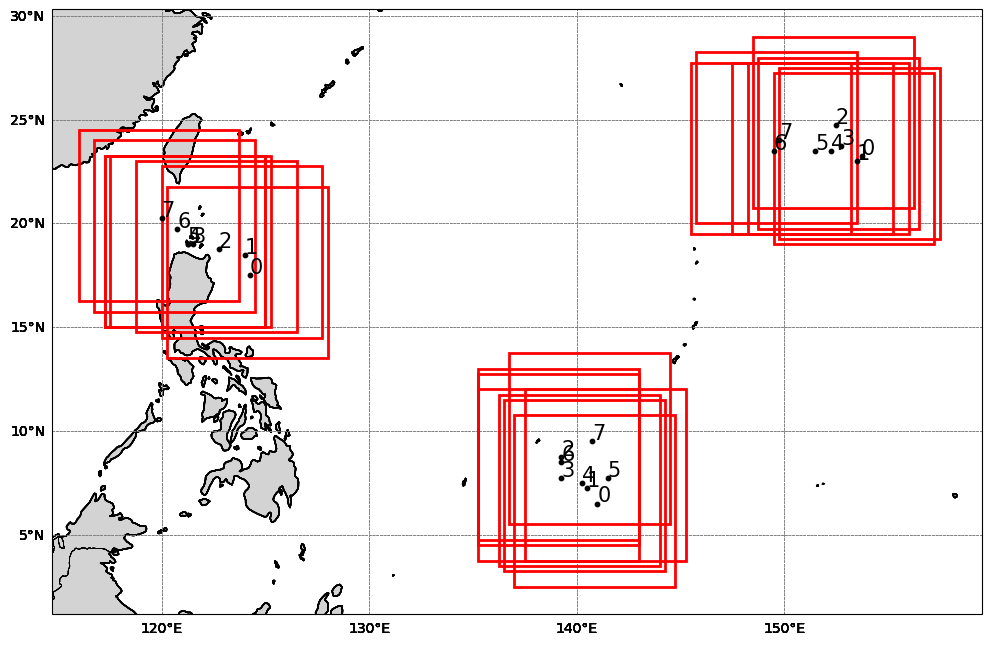

In [10]:
"""  将所有满足连续时刻的点都画在同一张图上 """
wOfBox, hOfBox = 16, 16
vmin = np.min(vo_smth)  # 或者用 np.percentile(self.vo, 1)
vmax = np.max(vo_smth)  # 或者用 np.percentile(self.vo, 99)

fig, axes = plt.subplots( 1,1, figsize=(12, 10),
                        subplot_kw={'projection': ccrs.PlateCarree()})
ax = axes
# 用于存储每个子图的 contourf 对象（用于 colorbar）
for i in range(len(timeOfSpecific)):     
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='white')
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)

    # 网格线
    gl = ax.gridlines(draw_labels=True,
                    x_inline=False, y_inline=False,
                    linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    # # 画框
    colorlist = ['red', 'green', 'blue', 'yellow', 'purple', 'orange', 'gray', 'pink']
    if test_list is not None:
        # 下方为测试散点    
        for i_point_test in tracked_list[i]: 
            print(i_point_test)
            x_test , y_test, id =  i_point_test
            
            test_lon_start = lons[x_test - wOfBox]
            test_lat_start = lats[y_test + hOfBox]
            lon_width = lons[x_test + wOfBox - 1] - test_lon_start 
            lat_height = lats[y_test - hOfBox - 1] - test_lat_start
            # ax.scatter(test_lon_start, test_lat_start,  左下角  

            ax.scatter(lons[x_test], lats[y_test],  
                           # c = colorlist[i],
                           c = 'k',
                           s= 10,  # s 是面积，相当于 markersize^2
                           transform=ccrs.PlateCarree(),
                           zorder=6)
            rect = Rectangle((test_lon_start, test_lat_start ),
                                 lon_width, lat_height,
                                 linewidth=2, 
                                 edgecolor='red', facecolor='none',
                                 linestyle='-', 
                                 zorder=5,
                                 transform=ccrs.PlateCarree())
            ax.add_patch(rect)

            # 标记点对应的时刻的索引
            ax.text(
                lons[x_test],  # x 坐标（经度）
                lats[y_test] + 0.1,  # y 坐标（纬度）稍微上移 0.1 度
                str(i),  # 标注内容（这里用 `i` 作为示例）
                # color=colorlist[i],
                color = 'k',
                fontsize= 15,
                transform=ccrs.PlateCarree(),
                zorder=7  # 确保文本在散点和矩形之上
        )


# 判断发展扰动还是不发展扰动

## 用csv文件

In [11]:
import pandas as pd 
file_pth = r"C:\Users\2892706668\Desktop\ibtracs.WP.list.v04r01.csv"
tc_data = pd.read_csv(file_pth)
print(tc_data)

C:\Users\2892706668\AppData\Local\Temp\ipykernel_24228\1432482976.py:3: DtypeWarning: Columns (1,2,8,9,14,142,143,144,172,173) have mixed types. Specify dtype option on import or set low_memory=False.
  tc_data = pd.read_csv(file_pth)


                  SID SEASON NUMBER BASIN SUBBASIN     NAME  \
0                       Year                                  
1       1884177N17124   1884     14    WP       MM  UNNAMED   
2       1884177N17124   1884     14    WP       MM  UNNAMED   
3       1884177N17124   1884     14    WP       MM  UNNAMED   
4       1884177N17124   1884     14    WP       MM  UNNAMED   
...               ...    ...    ...   ...      ...      ...   
245588  2025205N13144   2025     48    WP       MM    KROSA   
245589  2025205N13144   2025     48    WP       MM    KROSA   
245590  2025205N13144   2025     48    WP       MM    KROSA   
245591  2025205N13144   2025     48    WP       MM    KROSA   
245592  2025205N13144   2025     48    WP       MM    KROSA   

                   ISO_TIME NATURE            LAT           LON  ...  \
0                                   degrees_north  degrees_east  ...   
1       1884-06-24 16:00:00     NR           16.5         124.0  ...   
2       1884-06-24 18:00:00

In [12]:
# mask = ((tc_data.ISO_TIME >= '2023-07-25 00:00:00')&(tc_data.ISO_TIME <= '2023-07-26 18:00:00'))
pd_time_range = pd.date_range(start='2023-07-25 00:00:00', end='2023-07-26 18:00:00', freq='6h')
tc_data['ISO_TIME'] = pd.to_datetime(tc_data['ISO_TIME'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
mask = tc_data.ISO_TIME.isin(pd_time_range)
tc_dataOfCleaning = tc_data[mask] 


['124.6' '123.8' '122.7' '121.5' '121.4' '121.0' '120.6' '120.0' '141.1'
 '141.3' '141.0']


In [13]:
# print(tc_dataOfCleaning.ISO_TIME.values)
# print("pd_time_range:")


In [51]:
# 储存不同时刻台风位置和 i_sid 
all_SIDs = tc_dataOfCleaning.SID.unique()
# 使用 groupby 一次性分组
all_t_TCPoints = []
for i_isotime, group in tc_dataOfCleaning.groupby('ISO_TIME'):
    i_t_TcPoints =  []
    i_t_lons= group['USA_LON'].values  # 某个时刻的所有台风的经度
    i_t_lats = group['USA_LAT'].values
    i_t_sids = group['SID']
    for i_lon, i_lat, i_sid in zip(i_t_lons, i_t_lats, i_t_sids):
        i_t_TcPoints.append((np.float64(i_lon), np.float64(i_lat), i_sid))
    all_t_TCPoints.append(i_t_TcPoints)


In [49]:
print(all_t_TCPoints)

[[(124.6, 17.7, '2023201N13134')], [(123.8, 18.3, '2023201N13134')], [(122.7, 18.9, '2023201N13134')], [(121.5, 19.0, '2023201N13134')], [(121.4, 18.9, '2023201N13134')], [(121.0, 19.3, '2023201N13134'), (141.1, 9.0, '2023207N09141')], [(120.6, 19.6, '2023201N13134'), (141.3, 9.7, '2023207N09141')], [(120.0, 20.0, '2023201N13134'), (141.0, 10.6, '2023207N09141')]]


In [65]:
reso_km * 10

277.98731661139686

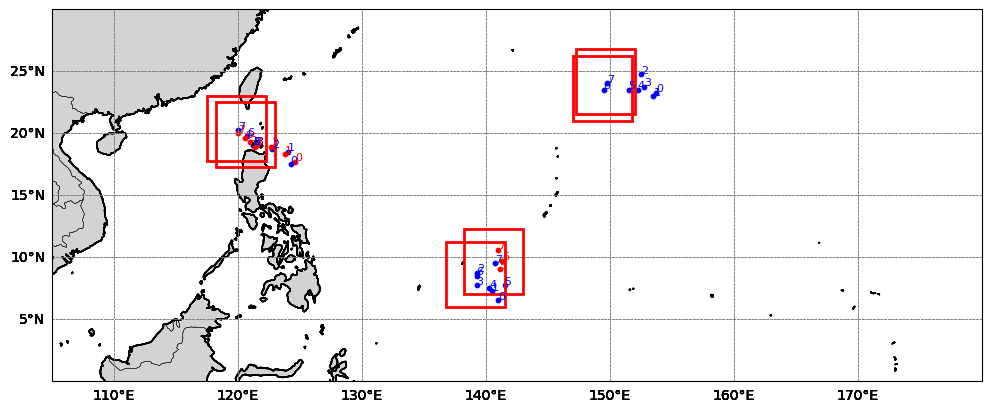

In [67]:
"""  将所有的时刻的点都画在同一张图上 """
# wOfBox, hOfBox = 16, 16
wOfBox, hOfBox = 10, 10 

vmin = np.min(vo_smth)  # 或者用 np.percentile(self.vo, 1)
vmax = np.max(vo_smth)  # 或者用 np.percentile(self.vo, 99)

fig, axes = plt.subplots( 1,1, figsize=(12, 10),
                        subplot_kw={'projection': ccrs.PlateCarree()})
ax = axes
# 用于存储每个子图的 contourf 对象（用于 colorbar）
ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()], crs=ccrs.PlateCarree())
for i in range(len(pd_time_range)):     
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='white')
    ax.add_feature(cfeature.COASTLINE,)
    ax.add_feature(cfeature.BORDERS, linewidth=0.1)

    # 网格线
    gl = ax.gridlines(draw_labels=True,
                    x_inline=False, y_inline=False,
                    linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    # # 画框
    colorlist = ['red', 'green', 'blue', 'yellow', 'purple', 'orange', 'gray', 'pink']
    if all_t_TCPoints is not None:
        # 下方为TC中心 
        for i_point_test in all_t_TCPoints[i]: 
            # print(i_point_test)
            x_test , y_test, sid =  i_point_test
            ax.scatter(  x_test, y_test  ,       #lons[x_test], lats[y_test],  
                           # c = colorlist[i],
                           c = 'r',
                           s= 10,  # s 是面积，相当于 markersize^2
                           zorder = 1, 
                           transform=ccrs.PlateCarree(),
                           )
            ax.text(
                x_test,  # x 坐标（经度）
                y_test + 0.1,  # y 坐标（纬度）稍微上移 0.1 度
                str(i),  # 标注内容（这里用 `i` 作为示例）
                # color=colorlist[i],
                color = 'r',
                fontsize= 8,
                transform=ccrs.PlateCarree(),
                zorder=7  # 确保文本在散点和矩形之上
                )
            
        # 下方为找到的所有的扰动中心  
        for i_point_test in tracked_list[i]: 
            # print(i_point_test)
            x_test , y_test , id =  i_point_test
            test_lon_start = lons[x_test - wOfBox]
            test_lat_start = lats[y_test + hOfBox]
            lon_width = lons[x_test + wOfBox - 1] - test_lon_start 
            lat_height = lats[y_test - hOfBox - 1] - test_lat_start
            # ax.scatter(test_lon_start, test_lat_start,    左下角  

            ax.scatter(  lons[x_test], lats[y_test],  
                           # c = colorlist[i],
                           c = 'blue',
                           s= 10,  # s 是面积，相当于 markersize^2
                           zorder = 0, 
                           transform=ccrs.PlateCarree()
                          ) 

            if i in [6, 7] :
                rect = Rectangle((test_lon_start, test_lat_start ),
                                     lon_width, lat_height,
                                     linewidth=2, 
                                     edgecolor='red', facecolor='none',
                                     linestyle='-', 
                                     zorder=5,
                                     transform=ccrs.PlateCarree())
                ax.add_patch(rect)
                
          
            #  # 标记点对应的时刻的索引
             
            ax.text(
                lons[x_test],  # x 坐标（经度）
                lats[y_test] + 0.1,  # y 坐标（纬度）稍微上移 0.1 度
                str(i),  # 标注内容（这里用 `i` 作为示例）
                # color=colorlist[i],
                color = 'blue',
                fontsize= 8,
                transform=ccrs.PlateCarree(),
                zorder=7  # 确保文本在散点和矩形之上
           )



## 判断发展扰动还是不发展扰动

In [ ]:
"""
1. 输入 总的扰动中心点的列表 和 台风位置的列表
2. 针对每个时刻, 以总的扰动中心点的列表为基准，w, h 来锁定真实lon, lat范围,
   判断框定范围内是否有 台风中心点,  如果有, 则将对应id 都删除,  否则就保留

"""

In [68]:
print(tracked_list) 

[[(144, 94, 0), (77, 50, 1), (195, 27, 2)], [(142, 91, 0), (76, 46, 1), (194, 28, 2)], [(137, 85, 0), (71, 45, 1), (190, 21, 2)], [(137, 89, 0), (66, 44, 1), (191, 25, 2)], [(141, 90, 0), (65, 44, 1), (189, 26, 2)], [(146, 89, 0), (65, 44, 1), (186, 26, 2)], [(137, 86, 0), (63, 41, 1), (178, 26, 2)], [(143, 82, 0), (179, 24, 2), (60, 39, 1)]]


In [132]:
def judegeDevOrNonDev(tracked_list: List[Tuple[float, float, Any]], 
                      all_t_TCPoints: List[Tuple[float, float, Any]],
                      wOfBox_degree: int = 10,  # 单位: 度
                      hOfBox_degree: int = 10):
    
    t_length = len(tracked_list)  # 时刻数量
    # tracked_list 的所有元素, 以tuple中的Any也就是id 为key , 其他两个float作为value
    track_PtsById = defaultdict(list)
    tc_PtsById = defaultdict(list)
    for frame in tracked_list:
        for x, y, id_ in frame:
            track_PtsById[id_].append((x, y))
    for frame in all_t_TCPoints:
        for x, y, id_ in frame:
            tc_PtsById[id_].append((x, y))
    print("开始出的 keys")
    print(track_PtsById.keys())
    # 对每个时刻的所有的点进行判断，判断是否是发展扰动还是不发展扰动
    for i_t in range(t_length):
        # 某个时刻具体的点 
        i_t_tracked_list = tracked_list[i_t]
        i_t_all_t_TCPoints = all_t_TCPoints[i_t]
        
        for i_pt in i_t_tracked_list:
            x_pt, y_pt, id_pt = i_pt
            # 以该点 为中心， 锁定 w, h 范围
            """ 注意: 此处假定两个列表的点都代表经纬度, 而不是索引值 """
            box = {
                "lon_min":  x_pt - wOfBox_degree,
                "lon_max":  x_pt + wOfBox_degree,
                "lat_min":  y_pt - hOfBox_degree,
                "lat_max":  y_pt + hOfBox_degree,
            }

            # 查看范围内是否有 tc 点
            for i_tc_point in i_t_all_t_TCPoints: 
                x_tc_pt, y_tc_pt, sid = i_tc_point
                if sid in tc_PtsById.keys():
                    if (x_tc_pt >= box["lon_min"]) and \
                       (x_tc_pt <= box["lon_max"]) and \
                       (y_tc_pt >= box["lat_min"]) and \
                       (y_tc_pt <= box["lat_max"]):
                        del tc_PtsById[sid]   # 删除键值对
                        del track_PtsById[id_pt]
    
    print("track_PtsById.keys()")
    print(track_PtsById.keys())
    # track_PtsById剩下的 key 就是不发展扰动的点, 删除的就是发展扰动的点
    
    final_nondev_centers = []
    final_dev_centers = []  
    for i_t in range(t_length):
        i_t_nondev_centers = []
        i_t_dev_centers = []
        
        i_t_tracked_list = tracked_list[i_t]
        # i_t_all_t_TCPoints = all_t_TCPoints[i_t]
        for i_track_point in i_t_tracked_list:
            x, y, id = i_track_point
            if id in track_PtsById.keys():
                # 扰动点
                i_t_nondev_centers.append((x, y, id))
            
            else:
                i_t_dev_centers.append((x, y, id))   # 后面得想办法把 sid 加进来, 可能得修改前面的代码
        final_nondev_centers.append(i_t_nondev_centers)
        final_dev_centers.append(i_t_dev_centers)
    return final_nondev_centers, final_dev_centers


In [133]:
# 扰动中心真实的lon, lat 坐标
final_nondev_centers, final_dev_centers = judegeDevOrNonDev(real_lonlatlist ,all_t_TCPoints )


开始出的 keys
dict_keys([0, 1, 2])
track_PtsById.keys()
dict_keys([2])


In [135]:
print(final_dev_centers)
print(final_nondev_centers)

[[(141.0, 6.5, 0), (124.25, 17.5, 1)], [(140.5, 7.25, 0), (124.0, 18.5, 1)], [(139.25, 8.75, 0), (122.75, 18.75, 1)], [(139.25, 7.75, 0), (121.5, 19.0, 1)], [(140.25, 7.5, 0), (121.25, 19.0, 1)], [(141.5, 7.75, 0), (121.25, 19.0, 1)], [(139.25, 8.5, 0), (120.75, 19.75, 1)], [(140.75, 9.5, 0), (120.0, 20.25, 1)]]
[[(153.75, 23.25, 2)], [(153.5, 23.0, 2)], [(152.5, 24.75, 2)], [(152.75, 23.75, 2)], [(152.25, 23.5, 2)], [(151.5, 23.5, 2)], [(149.5, 23.5, 2)], [(149.75, 24.0, 2)]]


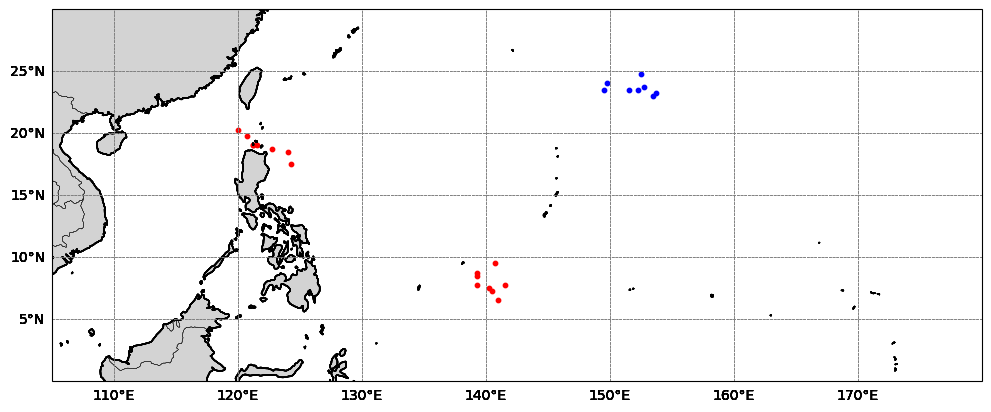

In [139]:
# 可视化

"""  将所有的时刻的点都画在同一张图上 """
# wOfBox, hOfBox = 16, 16
wOfBox, hOfBox = 10, 10

vmin = np.min(vo_smth)  # 或者用 np.percentile(self.vo, 1)
vmax = np.max(vo_smth)  # 或者用 np.percentile(self.vo, 99)

fig, axes = plt.subplots( 1,1, figsize=(12, 10),
                        subplot_kw={'projection': ccrs.PlateCarree()})
ax = axes
# 用于存储每个子图的 contourf 对象（用于 colorbar）
ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()], crs=ccrs.PlateCarree())
for i in range(len(pd_time_range)):     
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='white')
    ax.add_feature(cfeature.COASTLINE,)
    ax.add_feature(cfeature.BORDERS, linewidth=0.1)

    # 网格线
    gl = ax.gridlines(draw_labels=True,
                    x_inline=False, y_inline=False,
                    linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    # # 画框
    colorlist = ['red', 'green', 'blue', 'yellow', 'purple', 'orange', 'gray', 'pink']
    if final_dev_centers is not None:
        # 下方为TC中心 
        for i_point_test in final_dev_centers[i]: 
            # print(i_point_test)
            x_test , y_test, sid =  i_point_test
            ax.scatter(  x_test, y_test  ,       #lons[x_test], lats[y_test],  
                           # c = colorlist[i],
                           c = 'r',
                           s= 10,  # s 是面积，相当于 markersize^2
                           zorder = 1, 
                           transform=ccrs.PlateCarree(),
                           )
            # ax.text(
            #     x_test,  # x 坐标（经度）
            #     y_test + 0.1,  # y 坐标（纬度）稍微上移 0.1 度
            #     str(i),  # 标注内容（这里用 `i` 作为示例）
            #     # color=colorlist[i],
            #     color = 'r',
            #     fontsize= 8,
            #     transform=ccrs.PlateCarree(),
            #     zorder=7  # 确保文本在散点和矩形之上
            #     )
            
        # 下方为找到的 non-dev 扰动中心  
        for i_point_test in final_nondev_centers[i]: 
            # print(i_point_test)
            x_test , y_test , id =  i_point_test
            test_lon_start = x_test
            test_lat_start = y_test
            lon_width = test_lon_start + wOfBox
            lat_height = test_lat_start + 10 
            # ax.scatter(test_lon_start, test_lat_start,    左下角  

            ax.scatter(  x_test, y_test,  
                           # c = colorlist[i],
                           c = 'blue',
                           s= 10,  # s 是面积，相当于 markersize^2
                           zorder = 0, 
                           transform=ccrs.PlateCarree()
                          ) 

            # if i in [6, 7] :
            #     rect = Rectangle((test_lon_start, test_lat_start ),
            #                          lon_width, lat_height,
            #                          linewidth=2, 
            #                          edgecolor='red', facecolor='none',
            #                          linestyle='-', 
            #                          zorder=5,
            #                          transform=ccrs.PlateCarree())
            #     ax.add_patch(rect)
                
          
            #  # 标记点对应的时刻的索引
             
           #  ax.text(
           #      lons[x_test],  # x 坐标（经度）
           #      lats[y_test] + 0.1,  # y 坐标（纬度）稍微上移 0.1 度
           #      str(i),  # 标注内容（这里用 `i` 作为示例）
           #      # color=colorlist[i],
           #      color = 'blue',
           #      fontsize= 8,
           #      transform=ccrs.PlateCarree(),
           #      zorder=7  # 确保文本在散点和矩形之上
           # )

